In [7]:
# Load the libraries
import glob
from SSIM_PIL import compare_ssim
from PIL import Image
import pandas as pd
from timeit import default_timer as timer
from tqdm.notebook import tqdm
from statistics import mean
import matplotlib.pyplot as plt
import imagehash
from torch import nn
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import numpy as np
from scipy.spatial import distance

In [8]:
# Read the filenames
custom_dataset = glob.glob("Dataset/SFBench/*")
# Sort according to image numbers
custom_dataset.sort()

# The dataframe rows are all the dataset images
dataset_rows = custom_dataset
# the dataframe column is every 4th image in the dataset (refernece images)
dataset_columns = [filename for i, filename in enumerate(custom_dataset) if i%4 == 0]

# Build the dataframe
df = pd.DataFrame(columns = dataset_columns, index = dataset_rows)

In [12]:
def compute_similarity(df, method, visualize=False):
    
    # Load the model and set it to evaluation mode
    if method.startswith("efficientnet-b0"):
        model = EfficientNet.from_pretrained('efficientnet-b0')
        model.eval()
    
    # Compare images
    time_list = []
    for r, row in enumerate(tqdm(df.index)):
        image1 = Image.open(row)
        h1, w1 = image1.size
        image1 = image1.resize((int(h1/7), int(w1/7))) # to ease the computataion process
        for c, column in enumerate(tqdm(df.columns, leave=False)):
            if column != row: # so we dont compare the image to itself
                image2 = Image.open(column)
                image2 = image2.resize((int(h1/7), int(w1/7))) # to ease the computataion process
                start_time = timer()

                if method == "SSIM" or method == "ssim":
                #  Compare images using CPU-only version
                    value = round(compare_ssim(image1, image2, GPU=False),4)
                    
                elif method == "average-hash":
                    hash1 = imagehash.average_hash(image1)
                    hash2 = imagehash.average_hash(image2)
                    value = round(hash1-hash2, 4)   
                    
                elif method == "cosine-similarity":
                    image1_tensor = transforms.ToTensor()(image1).reshape(1, -1).squeeze()
                    image2_tensor = transforms.ToTensor()(image2).reshape(1, -1).squeeze()
                    cos = nn.CosineSimilarity(dim=0)
                    value = round(float(cos(image1_tensor, image2_tensor)),4)
                    
                elif method == "efficientnet-b0-cosine-similarity":
                    image1_tensor = transforms.ToTensor()(image1)
                    image2_tensor = transforms.ToTensor()(image2)
                    features1 = model.extract_features(image1_tensor.unsqueeze(0))
                    features2 = model.extract_features(image2_tensor.unsqueeze(0))
                    cos = nn.CosineSimilarity(dim=0)
                    value = round(float(cos(features1.reshape(1, -1).squeeze(), \
                                            features2.reshape(1, -1).squeeze())),4)
                    
                elif method == "efficientnet-b0-euclidean-distance":
                    image1_tensor = transforms.ToTensor()(image1)
                    image2_tensor = transforms.ToTensor()(image2)
                    features1 = model.extract_features(image1_tensor.unsqueeze(0))
                    features2 = model.extract_features(image2_tensor.unsqueeze(0))
                    value = round(np.linalg.norm(np.array(features1.detach()) \
                                                 - np.array(features2.detach())), 4)

                elif method == "euclidean-distance":
                    value = round(np.linalg.norm(np.array(image1) - np.array(image2)), 4)
                    
                end_time = timer()
                elapsed_time = end_time - start_time
                time_list.append(elapsed_time) # Append the time to a list to later get the average
                df.loc[row, column] = value
                image2.close()
        image1.close()
        
    # Average running time
    avg_time = round(mean(time_list),4)
    
    # Pick highes 3 scores
    if method == 'average-hash' or method == "efficientnet-b0-euclidean-distance" or method == "euclidean-distance":
        df = df.fillna(np.inf) # To neglect the reference images
    else:
        df = df.fillna(0) # To neglect the reference images
        
    similar_images_dict = {}
    if method == "average-hash" or method == "efficientnet-b0-euclidean-distance" or method == "euclidean-distance":
        for column in df.columns:
            similar_images_dict[column] = list(df.nsmallest(n=3, columns=column)[column].index)
    else:
        for column in df.columns:
            similar_images_dict[column] = list(df.nlargest(n=3, columns=column)[column].index)
    
    # Plot
    if visualize == True:
        _, axs = plt.subplots(10, 4, figsize=(12, 20))
        axs = axs.flatten()
        i = 0
        j = 1
        for key, values in similar_images_dict.items():
            image1 = Image.open(key)
            h1, w1 = image1.size
            image1 = image1.resize((int(h1/7), int(w1/7)))
            axs[i].imshow(image1)
            axs[i].title.set_text("reference")

            for value in values:
                image2 = Image.open(value)
                h2, w2 = image2.size
                image2 = image2.resize((int(h2/7), int(w2/7)))
                axs[i+j].imshow(image2)
                axs[i+j].title.set_text(df.loc[value][key])
                i = i+j
            i += 1
        plt.show()
    
    # Compute accuracy
    # If you want to use your dataset, you have to follow the same naming convention so 
    # the accuracy can be calculated
    positive_predictions = 0
    for k,values in similar_images_dict.items():
        key_num = int(k[k.find("/SFBench/")+len("/SFBench/"):k.rfind(".jpg")])
        for v in values:
            value_num = int(v[v.find("/SFBench/")+len("/SFBench/"):v.rfind(".jpg")])
            if (value_num == key_num + 1) | (value_num == key_num + 2) | (value_num == key_num + 3):
                positive_predictions += 1
    final_accuracy = round(positive_predictions/(len(df)-len(df.columns))*100,4)
    print(f"The accuracy using {method} is {final_accuracy}, average computing time: {avg_time}")
    
    return final_accuracy, avg_time

In [10]:
euclidean_acc, euclidean_speed = compute_similarity(df, "euclidean-distance", visualize=False)


The accuracy using euclidean-distance is 10.0, average computing time: 0.0069


In [11]:
SSIM_acc, SSIM_speed = compute_similarity(df, "SSIM", visualize=False)


The accuracy using SSIM is 13.3333, average computing time: 0.48


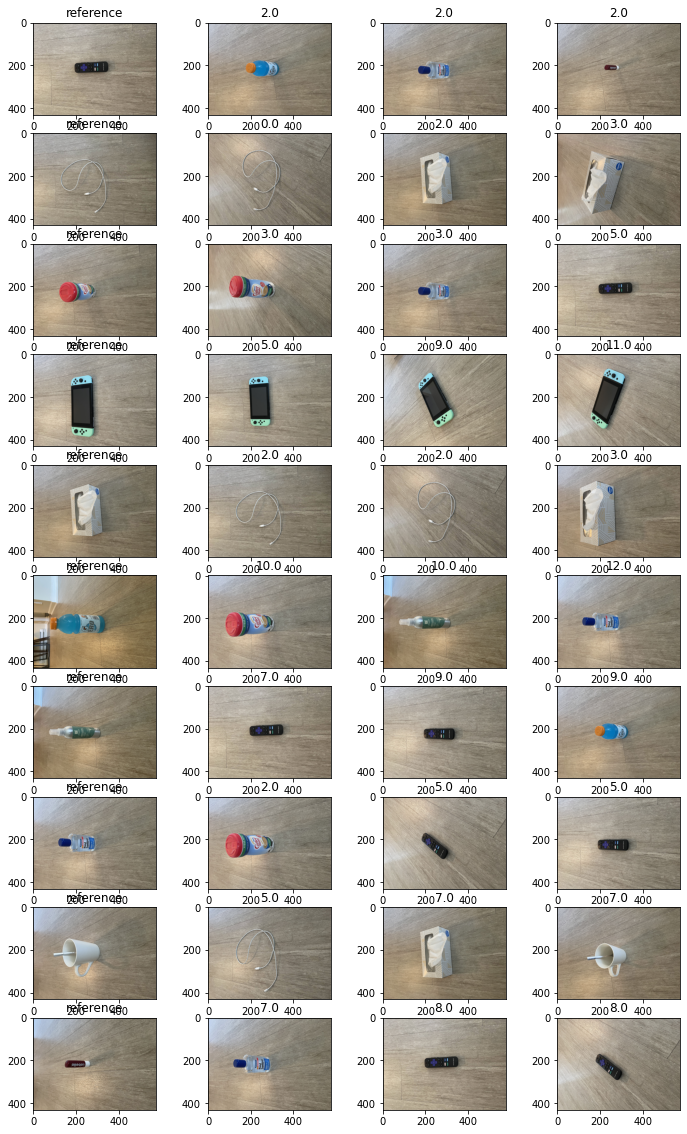

The accuracy using average-hash is 23.3333, average computing time: 0.0022


In [13]:
average_hash_acc, average_hash_speed = compute_similarity(df, "average-hash", visualize=True)

In [14]:
cosine_similarity_acc, cosine_similarity_speed = compute_similarity(df, "cosine-similarity", visualize=False)


The accuracy using cosine-similarity is 36.6667, average computing time: 0.0087


Loaded pretrained weights for efficientnet-b0


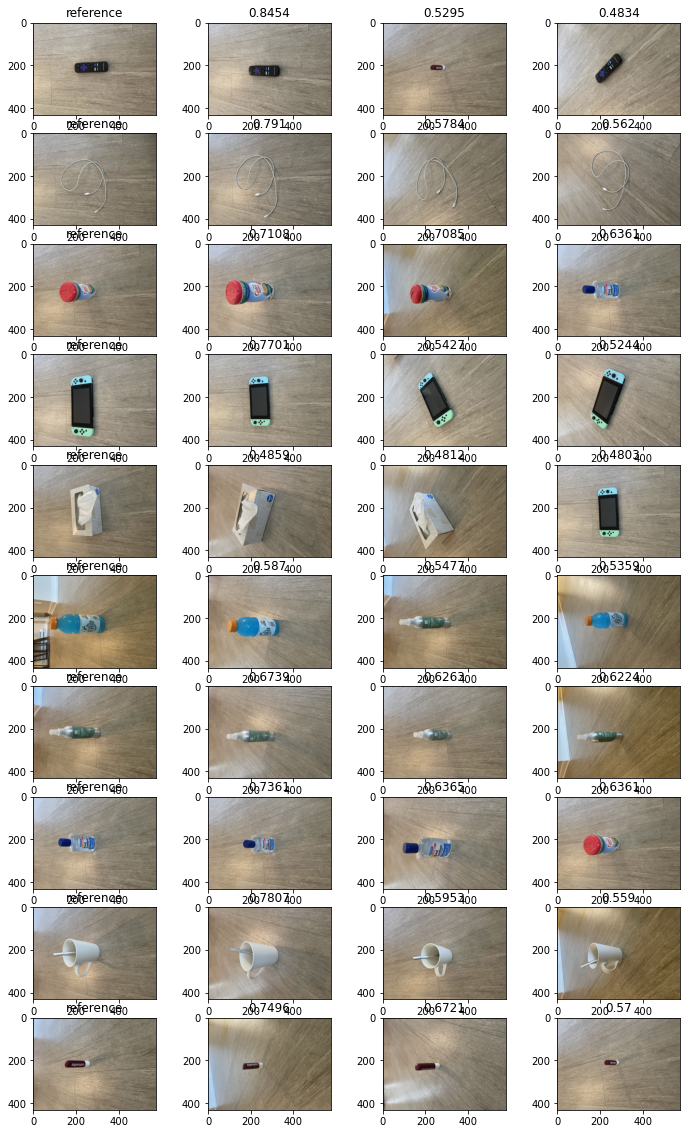

The accuracy using efficientnet-b0-cosine-similarity is 83.3333, average computing time: 0.7624


In [15]:
effnet_acc, effnet_speed = compute_similarity(df, "efficientnet-b0-cosine-similarity", visualize=True)

Loaded pretrained weights for efficientnet-b0


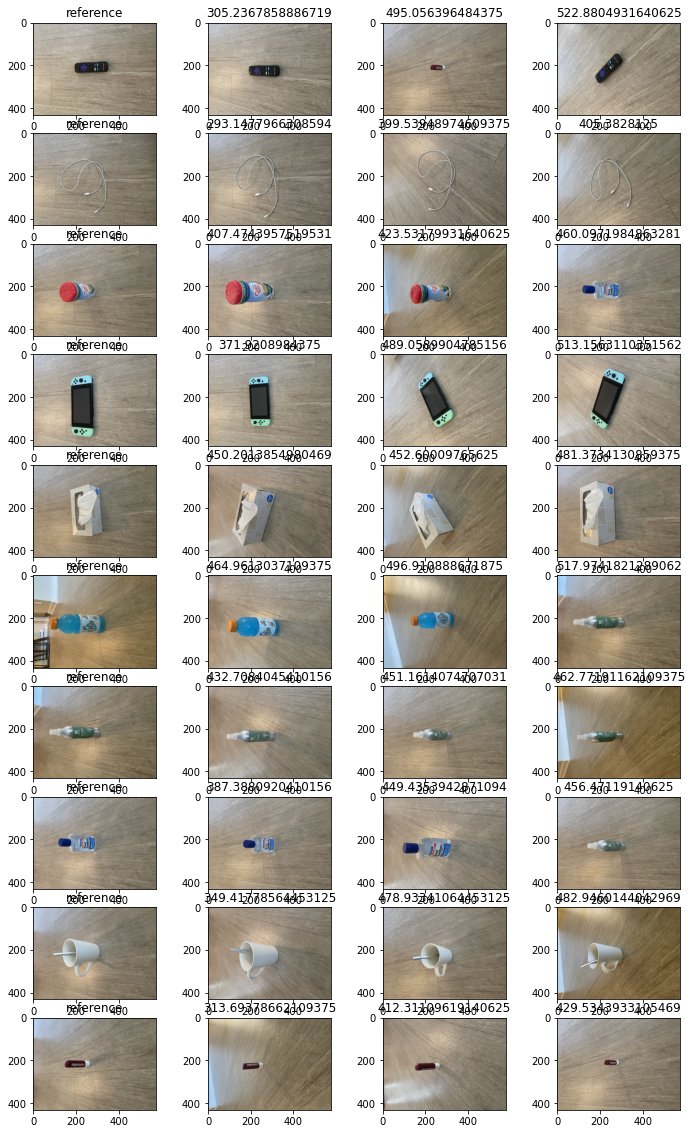

The accuracy using efficientnet-b0-euclidean-distance is 86.6667, average computing time: 0.76


In [16]:
effnet_euc_acc, effnet_euc_speed = compute_similarity(df, "efficientnet-b0-euclidean-distance", visualize=True)